## **TER**

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
from IPython.display import display, HTML

# chemin en modifer
chemin = "/Users/thomassinapi/Desktop/M1 Data Science/TER/dataprojectstage_masterUPS.xlsx"

df = pd.read_excel(chemin)

In [69]:
from piml import Experiment
exp = Experiment(highcode_only=True)

---
## ***Visualisation des données***
---

In [70]:
# transforme les variables ages en catégories (18-23, 24-30, 31-40, 41-50, 51-60, 61-70, 71-90)
df['Age'] = pd.cut(df['Age'], bins=[0, 23, 30, 40, 50, 60, 70, 100], labels=['18-23', '24-30', '31-40', '41-50', '51-60', '61-70', '71-100'])
df['Age'].value_counts()

51-60     1760
41-50     1711
31-40     1332
24-30      967
61-70      738
18-23      570
71-100     362
Name: Age, dtype: int64

In [71]:
# transforme les variables job tenure en catégories (0-2, 3-5, 6-10, 11-20, 21-30, 31-40, 41-80)
df['Job tenure'] = pd.cut(df['Job tenure'], bins=[-1, 1, 2, 5, 10, 20, 30, 40, 82], labels=['0-1', '1-2', '3-5', '6-10', '11-20', '21-30', '31-40', '41-82'])
df['Job tenure'].value_counts()

0-1      1786
11-20    1350
3-5      1313
6-10     1224
21-30     771
1-2       646
31-40     291
41-82      59
Name: Job tenure, dtype: int64

In [72]:
df.groupby('Age').size()

Age
18-23      570
24-30      967
31-40     1332
41-50     1711
51-60     1760
61-70      738
71-100     362
dtype: int64

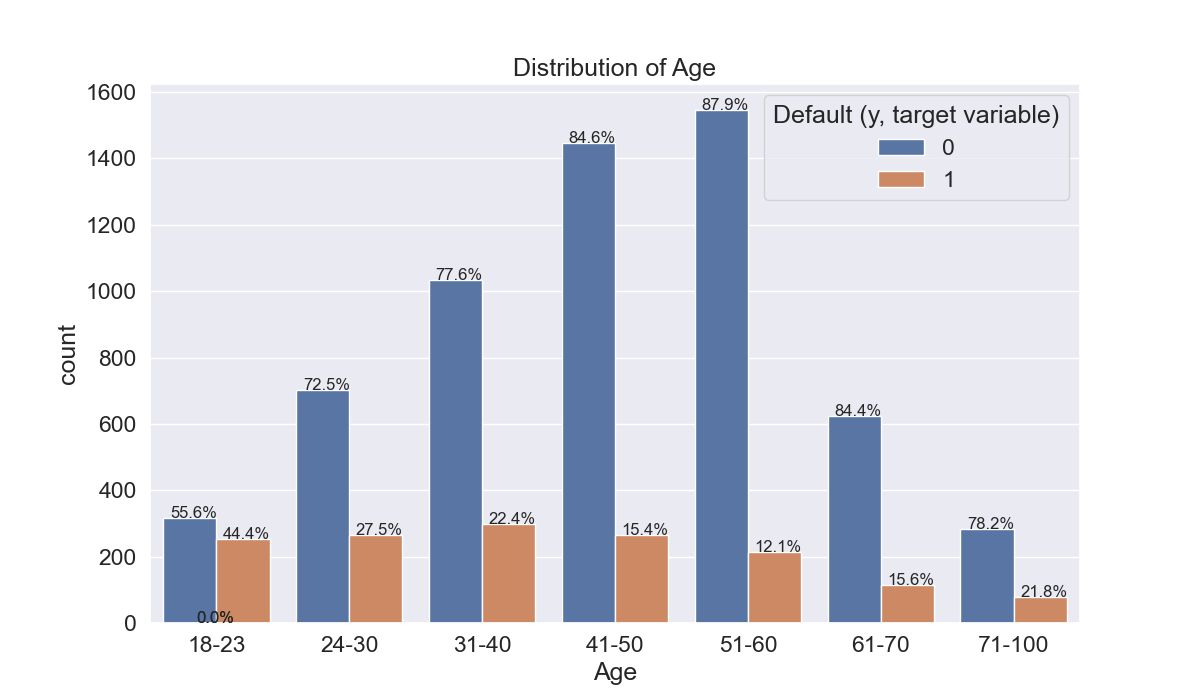

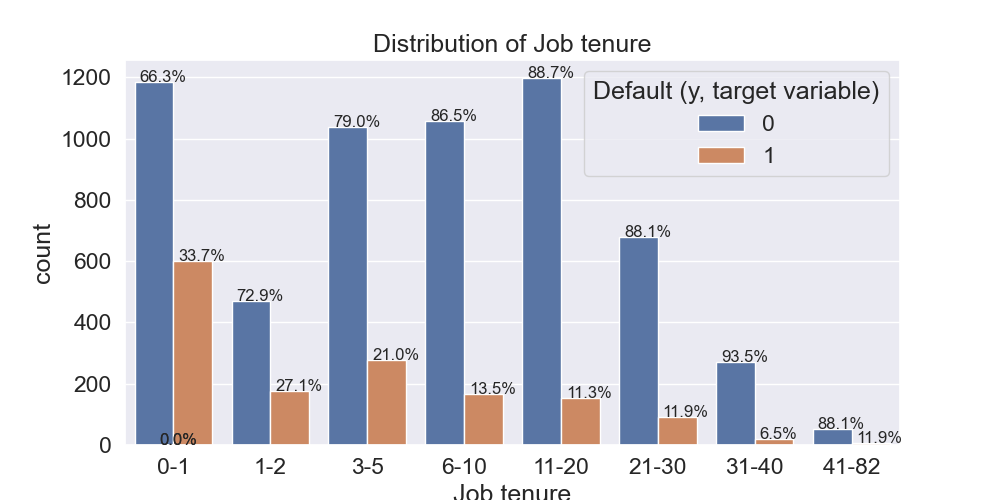

In [73]:
from matplotlib.pyplot import scatter

# distribution de la variable cible en fonction de l'age
plt.figure(figsize=(12,7))
plot = sns.countplot(x='Age', hue='Default (y, target variable)', data=df)
plt.title('Distribution of Age')

# Calculer le total par catégorie
totals = df.groupby('Age').size()

# Ajouter le pourcentage à chaque barre
for i, p in enumerate(plot.patches):
    category = plot.get_xticks()[i % len(plot.get_xticks())]
    total = totals[category]
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    plot.annotate(percentage, (x, y), size = 12)
plt.show()

# distribution de la variable cible en fonction de l'ancienneté
plt.figure(figsize=(10,5))
plot = sns.countplot(x='Job tenure', hue='Default (y, target variable)', data=df)
plt.title('Distribution of Job tenure')

# Calculer le total par catégorie
totals = df.groupby('Job tenure').size()

# Ajouter le pourcentage à chaque barre
for i, p in enumerate(plot.patches):
    category = plot.get_xticks()[i % len(plot.get_xticks())]
    total = totals[category]
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    plot.annotate(percentage, (x, y), size = 12)
plt.show()

---
#### ***Standardisation des données numériques***
---

In [74]:
from sklearn.preprocessing import StandardScaler

# standard scaler pour numeric variables uniquement sans la variable cible
scaler = StandardScaler()
df_numeric = df.select_dtypes(include=['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['Default (y, target variable)'])
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=df_numeric.columns)




---
#### ***Encodage variables catégorielles***
---

In [75]:
# One hot encoding pour les variables catégorielles
from sklearn.preprocessing import OneHotEncoder
#encoder = OneHotEncoder(handle_unknown="error")
#age_encod = encoder.fit_transform(df[["Age"]]).toarray()
#df_age_encoded = pd.DataFrame(age_encod, columns=encoder.get_feature_names_out())
#jobtenure_encod = encoder.fit_transform(df[["Job tenure"]]).toarray()
#df_jobtenure_encoded = pd.DataFrame(jobtenure_encod, columns=encoder.get_feature_names_out())

#df1 = pd.concat([df_scaled, df_age_encoded], axis=1)
#df1 = pd.concat([df1, df_jobtenure_encoded], axis=1)
#df1 = pd.concat([df1, df["Default (y, target variable)"]], axis=1)
df1 = pd.concat([df_scaled, df["Default (y, target variable)"]], axis=1)

---
## ***Train Test Split***
---

In [191]:
from sklearn.model_selection import train_test_split
X = df1.drop("Default (y, target variable)", axis=1)
X = X.drop("ID", axis=1) # colonne inutile
y = df1["Default (y, target variable)"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"TRAIN SIZE: {X_train.shape[0], y_train.shape[0]} -> {X_train.shape[0] / X.shape[0] * 100:.2f}%")
# print(f"VAL   SIZE: {X_val.shape[0], y_val.shape[0]} -> {X_val.shape[0] / X.shape[0] * 100:.2f}%")
print(f"TEST  SIZE: {X_test.shape[0], y_test.shape[0]} -> {X_test.shape[0] / X.shape[0] * 100:.2f}%")

# print repartition des classes dans chaque set
print(f"TRAIN: {y_train.value_counts(normalize=True)}")
# print(f"VAL  : {y_val.value_counts(normalize=True)}")
print(f"TEST : {y_test.value_counts(normalize=True)}")

TRAIN SIZE: (5952, 5952) -> 80.00%
TEST  SIZE: (1488, 1488) -> 20.00%
TRAIN: 0    0.799731
1    0.200269
Name: Default (y, target variable), dtype: float64
TEST : 0    0.801075
1    0.198925
Name: Default (y, target variable), dtype: float64


---
## ***PCA***
---

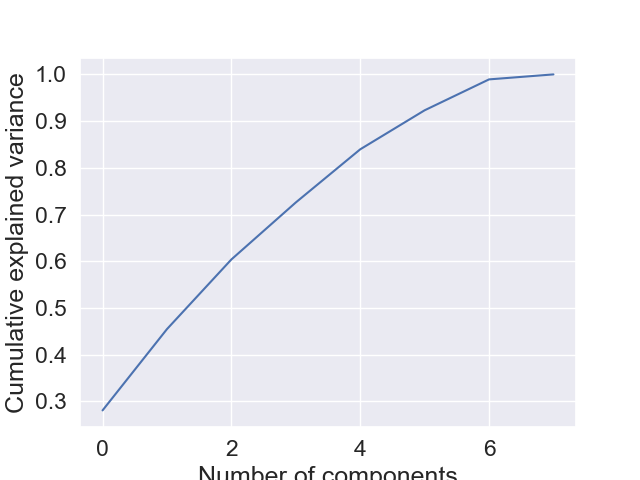

In [176]:
# proportion of variance explained en fonction du nombre de composantes
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


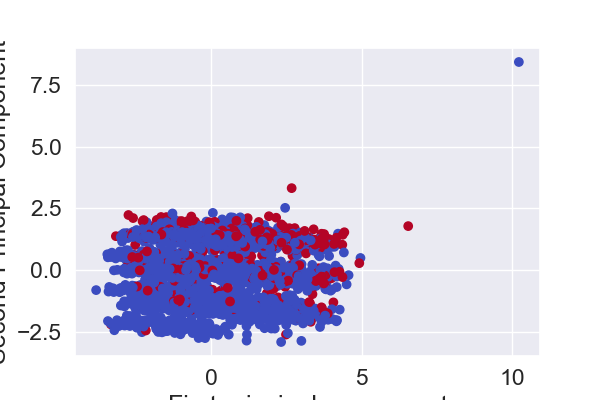

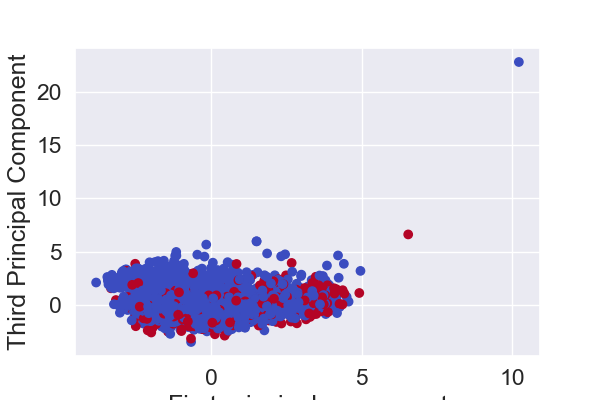

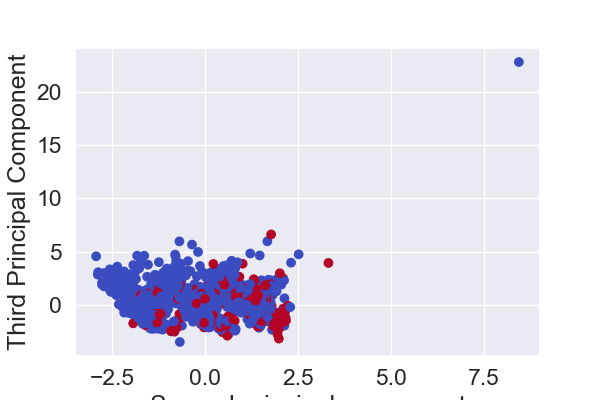

In [177]:
# pca
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# plot pca
plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 2], c=y_train, cmap='coolwarm')
plt.xlabel('First principal component')
plt.ylabel('Third Principal Component')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='coolwarm')
plt.xlabel('Second principal component')
plt.ylabel('Third Principal Component')
plt.show()



In [178]:
# slider dans tous les axes pour voir les composantes
from ipywidgets import interact, fixed
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_pca(i, j, k):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_train_pca[:, i-1], X_train_pca[:, j-1], X_train_pca[:, k-1], c=y_train, label="Default", cmap='coolwarm')
    ax.set_xlabel(f"PCA {i}")
    ax.set_ylabel(f"PCA {j}")
    ax.set_zlabel(f"PCA {k}")
    cbar = plt.colorbar(scatter)
    cbar.set_label("Target")
    plt.title("PCA 3D Components Visualization")
    plt.show()

interact(plot_3d_pca, i=(1,3), j=(1, 3), k=(1, 3))


# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(X_train_pca[:, 2], X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, label="Default", cmap='coolwarm')
# ax.set_xlabel("PCA 1")
# ax.set_ylabel("PCA 2")
# ax.set_zlabel("PCA 3")
# cbar = plt.colorbar(scatter)
# cbar.set_label("Target")
# plt.title("PCA 3D Components Visualization")
# plt.show()

interactive(children=(IntSlider(value=2, description='i', max=3, min=1), IntSlider(value=2, description='j', m…

<function __main__.plot_3d_pca(i, j, k)>

---
## ***Modèles***
---

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
# dummy classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(),
    "KNN": KNeighborsClassifier(),

    "Naive Bayes": GaussianNB(),
    "Dummy": DummyClassifier( strategy='most_frequent', random_state=42)   # COMPARAISON IMPORTANTE
}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)

# plot un tableau avec les scores
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
print(model_compare.T)



# confusion matrix
y_preds = models['XGBoost'].predict(X_test)
confusion_matrix(y_test, y_preds)
# plot confusion matrix
sns.set(font_scale=1.5)
def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.ylabel("true label")
    plt.xlabel("predicted label")

plot_conf_mat(y_test, y_preds)

# roc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc



# plot roc curve

def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} AUC: {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], "--", label="Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

plot_roc_curve(models, X_test, y_test)






KeyboardInterrupt: 

### ***Evaluate Classifier***

In [192]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from IPython.display import display, HTML
from sklearn.metrics import r2_score

def evaluate_classifier(clf, display_html= True):
    name = getattr(clf, 'name', clf.__class__.__name__)
    clf.fit(X_train, y_train)

    # Vérifie si le classificateur a une méthode `predict_proba`
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]  # scores de la classe positive
        auc_score = roc_auc_score(y_test, y_proba)
    elif hasattr(clf, "decision_function"):  # Utiliser `decision_function` si disponible
        y_scores = clf.decision_function(X_test)
        auc_score = roc_auc_score(y_test, y_scores)
    else:
        auc_score = None

    y_pred = clf.predict(X_test)
    balanced_score = balanced_accuracy_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    cv_scores_balanced_accuracy = cross_val_score(clf, X_train, y_train, cv=5, scoring='balanced_accuracy')
    mean_cv_score_balanced_accuracy = np.mean(cv_scores_balanced_accuracy)

    if display_html:
        display(HTML(
            f"<h2>{name}</h2>"
            f"<span style='color:yellow;'><b>Balanced accuracy: {balanced_score:7.2%}</b></span> <br/>"
            f"<br/>"
            f"Cross-validation score (Balanced Accuracy): <span style='color:yellow;'> <b>{mean_cv_score_balanced_accuracy:7.2%}</b></span>  <br/>"
            f"<br/>"
            f"AUC: <b>{auc_score:7.2%}</b> <br/>" if auc_score is not None else ""
            f"<br/>"
        ))
    return round(balanced_score,3), round(auc_score,3)



def pca_evaluate_classifier(clf):
    name = getattr(clf, 'name', clf.__class__.__name__)
    clf.fit(X_train_pca, y_train)
    score = clf.score(X_test_pca, y_test)
    y_pred = clf.predict(X_test_pca)
    # Vérifie si le classificateur a une méthode `predict_proba`
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test_pca)[:, 1]  # scores de la classe positive
        auc_score = roc_auc_score(y_test, y_proba)
    elif hasattr(clf, "decision_function"):  # Utiliser `decision_function` si disponible
        y_scores = clf.decision_function(X_test_pca)
        auc_score = roc_auc_score(y_test, y_scores)
    else:
        auc_score = None

    balanced_score = balanced_accuracy_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    cv_scores_balanced_accuracy = cross_val_score(clf, X_train, y_train, cv=5, scoring='balanced_accuracy')
    mean_cv_score_balanced_accuracy = np.mean(cv_scores_balanced_accuracy)

    display(HTML(
        f"<h2>{name}</h2>"
        f"Test Accuracy: <b>{score:7.2%}</b> <br/>"
        f"<br/>"
        f"<span style='color:yellow;'><b>Balanced accuracy: {balanced_score:7.2%}</b></span> <br/>"
        f"<br/>"
        f"Cross-validation score (Balanced Accuracy): <span style='color:yellow;'> <b>{mean_cv_score_balanced_accuracy:7.2%}</b></span>  <br/>"
        f"<br/>"
        f"AUC: <b>{auc_score:7.2%}</b> <br/>" if auc_score is not None else ""
        f"<br/>"
        f"R2: <b>{r2:7.2%}</b> <br/>"
        f"<br/>"
    ))
    return round(balanced_score,3), round(auc_score,3)


---
## ***Grid Search***
---

---
## ***Tests différentes méthodes de preprocessing et modèles***
---

In [193]:
from sklearn.ensemble import RandomForestClassifier

model_rf = make_pipeline_imblearn(RandomForestClassifier(random_state=42))
model_rf.name = "SMOTE + Random Forest"
evaluate_classifier(model_rf)



(0.583, 0.736)

In [194]:
y_pred = model_rf.predict(X_test)
balanced_score = balanced_accuracy_score(y_test, y_pred)

cv_scores_balanced_accuracy = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='balanced_accuracy')
mean_cv_score_balanced_accuracy = np.mean(cv_scores_balanced_accuracy)
print(mean_cv_score_balanced_accuracy)
balanced_score

0.5678949404029394


0.5829289860330129

In [195]:
from xgboost import XGBClassifier

model_xg = make_pipeline_imblearn(SMOTE(),XGBClassifier())
model_xg.name = "SMOTE + XGBoost"

evaluate_classifier(model_xg)


(0.676, 0.752)

In [196]:
from sklearn.dummy import DummyClassifier
model = DummyClassifier(strategy='most_frequent', random_state=42)
evaluate_classifier(model)

# plot feature import

(0.5, 0.5)

In [197]:
from sklearn.linear_model import LogisticRegression

lreg = make_pipeline_imblearn(SMOTE(),LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear'))
lreg.name = "SMOTE + Logistic Regression"

evaluate_classifier(lreg)

(0.709, 0.783)

In [198]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = make_pipeline_imblearn(SMOTE(),KNeighborsClassifier())
model_knn.name = "SMOTE + KNN"
evaluate_classifier(model_knn)




(0.64, 0.694)

In [187]:
from sklearn.base import clone
model_lr_balanced = clone(model_xg)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
model_lr_balanced.set_params(scale_pos_weight = ratio)
model_lr_balanced.name = "XGBoost with balanced weights"
evaluate_classifier(model_lr_balanced)


ValueError: Invalid parameter 'scale_pos_weight' for estimator Pipeline(steps=[('smote', SMOTE()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [199]:
from sklearn.pipeline import make_pipeline

model_rf_balanced = make_pipeline_imblearn(SMOTE(),RandomForestClassifier(n_estimators=320,
                                 max_depth=10,
                                 min_samples_split=4,
                                 min_samples_leaf=1,
                                 class_weight='balanced'
                                 ))
model_rf_balanced.name = "Balanced Random Forest"

evaluate_classifier(model_rf_balanced)

KeyboardInterrupt: 

In [ ]:
from piml.models import ReluDNNClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Créez un pipeline qui inclut SMOTE et RandomForestClassifier
pipeline = make_pipeline_imblearn(SMOTE(random_state=42, k_neighbors=1), ReluDNNClassifier(hidden_layer_sizes=(40, 40), l1_reg=0.0008,
                        batch_size=500, learning_rate=0.001))

pipeline.name = "SMOTE + ReLUDNN"

evaluate_classifier(pipeline)


(0.703, 0.774)

In [ ]:
from piml.models import XGB2Classifier

model_xgb2 = make_pipeline_imblearn(SMOTE(random_state=42), XGB2Classifier())
model_xgb2.name = "SMOTE + XGB2"
evaluate_classifier(model_xgb2)

(0.696, 0.754)

In [ ]:
from piml.models import GAMINetClassifier

model_gaminet = make_pipeline_imblearn(SMOTE(random_state=42), GAMINetClassifier())
model_gaminet.name = "SMOTE + GAMINet"
evaluate_classifier(model_gaminet)

(0.733, 0.807)

In [200]:
models = [lreg,model_knn,model_rf,model_xg, lreg, model_rf_balanced,pipeline, model_xgb2]


def evaluate_models(models, evaluate_classifier):
    """
    Évalue une liste de modèles et retourne un DataFrame avec le balanced_accuracy et l'AUC de chaque modèle.

    Parameters:
    - models: liste de modèles à évaluer.
    - evaluate_classifier: fonction qui prend en entrée un modèle et retourne (balanced_accuracy, AUC).

    Returns:
    - DataFrame pandas avec les colonnes 'Modèle', 'Balanced Accuracy', 'AUC'.
    """
    # Initialiser les listes pour stocker les résultats
    model_names = []
    balanced_accuracies = []
    aucs = []

    # Boucler sur chaque modèle, l'évaluer et stocker ses performances
    for model in models:
        balanced_accuracy, auc = evaluate_classifier(model, False)
        model_names.append(str(model.name))  # Utiliser str(model) ou une autre méthode pour nommer les modèles
        balanced_accuracies.append(balanced_accuracy)
        aucs.append(auc)

    # Créer un DataFrame avec les résultats
    results_df = pd.DataFrame({
        'Modèle': model_names,
        'Balanced Accuracy': balanced_accuracies,
        'AUC': aucs
    })

    return results_df


models_evaluated = evaluate_models(models,evaluate_classifier)

In [201]:
models_evaluated # 42

,Modèle,Balanced Accuracy,AUC
0,SMOTE + Logistic Regression,0.710,0.783
1,SMOTE + KNN,0.643,0.696
2,SMOTE + Random Forest,0.583,0.736
3,SMOTE + XGBoost,0.683,0.757
4,SMOTE + Logistic Regression,0.714,0.783
5,Balanced Random Forest,0.699,0.768
6,SMOTE + ReLUDNN,0.722,0.792
7,SMOTE + XGB2,0.711,0.779


In [190]:
models_evaluated # 7

,Modèle,Balanced Accuracy,AUC
0,SMOTE + Logistic Regression,0.694,0.754
1,SMOTE + KNN,0.617,0.667
2,SMOTE + Random Forest,0.558,0.716
3,SMOTE + XGBoost,0.662,0.718
4,SMOTE + Logistic Regression,0.695,0.753
5,Balanced Random Forest,0.677,0.735
6,SMOTE + ReLUDNN,0.701,0.758
7,SMOTE + XGB2,0.696,0.754


In [170]:
models_evaluated #0

,Modèle,Balanced Accuracy,AUC
0,SMOTE + Logistic Regression,0.707,0.778
1,SMOTE + KNN,0.626,0.669
2,SMOTE + Random Forest,0.540,0.727
3,SMOTE + XGBoost,0.650,0.739
4,SMOTE + Logistic Regression,0.706,0.781
5,Balanced Random Forest,0.700,0.755
6,SMOTE + ReLUDNN,0.703,0.774
7,SMOTE + XGB2,0.722,0.774


#### ***Comparaison des résultats obtenus des différents modèles peu sattisfaisants par rapport au Dummy Classifier***

In [55]:
import matplotlib.pyplot as plt
import numpy as np

models = [model_rf_balanced, model_knn, lreg, model_rf, model_xg, model, relu, xgb]


def evaluate_models(models, evaluate_classifier):
    """
    Évalue une liste de modèles et retourne un DataFrame avec le balanced_accuracy et l'AUC de chaque modèle.

    Parameters:
    - models: liste de modèles à évaluer.
    - evaluate_classifier: fonction qui prend en entrée un modèle et retourne (balanced_accuracy, AUC).

    Returns:
    - DataFrame pandas avec les colonnes 'Modèle', 'Balanced Accuracy', 'AUC'.
    """
    # Initialiser les listes pour stocker les résultats
    model_names = []
    balanced_accuracies = []
    aucs = []

    # Boucler sur chaque modèle, l'évaluer et stocker ses performances
    for model in models:
        balanced_accuracy, auc = evaluate_classifier(model)
        model_names.append(str(model))  # Utiliser str(model) ou une autre méthode pour nommer les modèles
        balanced_accuracies.append(balanced_accuracy)
        aucs.append(auc)

    # Créer un DataFrame avec les résultats
    results_df = pd.DataFrame({
        'Modèle': model_names,
        'Balanced Accuracy': balanced_accuracies,
        'AUC': aucs
    })

    return results_df


evaluate_models(models,evaluate_classifier)




,Modèle,Balanced Accuracy,AUC
0,"Pipeline(steps=[('randomforestclassifier',\n ...",0.680,0.752
1,KNeighborsClassifier(),0.589,0.676
2,"LogisticRegression(C=100, max_iter=1000, solve...",0.551,0.763
3,RandomForestClassifier(),0.567,0.733
4,"XGBClassifier(base_score=None, booster=None, c...",0.605,0.725
5,"DummyClassifier(random_state=42, strategy='mos...",0.500,0.500
6,"Pipeline(steps=[('reludnnclassifier', ReluDNNC...",0.553,0.782
7,XGB2Classifier(),0.565,0.762


from matplotlib import pyplot as plt
_df_0['Balanced Accuracy'].plot(kind='hist', bins=20, title='Balanced Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['AUC'].plot(kind='hist', bins=20, title='AUC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Modèle').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Balanced Accuracy', y='AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Balanced Accuracy'].plot(kind='line', figsize=(8, 4), title='Balanced Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['AUC'].plot(kind='line', figsize=(8, 4), title='AUC')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['Modèle'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='Balanced Accuracy', y='Modèle', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['Modèle'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='AUC', y='Modèle', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Validation ...

In [129]:
exp.data_loader(data=df)

,ID,Job tenure,Age,Car price,Funding amount,Down payment,Loan duration,Monthly payment,Credit event,Married,Homeowner,"Default (y, target variable)"
0,1,34,55,4875,3087,0,36,0.0479,0,1,1,0
2,3,14,38,17190,14190,0,60,0.0882,0,0,0,0
3,4,16,37,22773,23568,0,48,0.1101,0,1,1,0
5,6,17,50,10250,5750,0,48,0.1102,0,0,1,0
6,7,8,45,8050,6050,0,48,0.0604,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4007,4008,0,25,3150,2925,0,24,0.0938,0,0,0,1
7284,7285,2,20,16877,17016,0,72,0.0871,0,0,0,1
1046,1047,10,70,7190,8393,0,60,0.1436,1,0,0,1
1157,1158,4,59,12909,12011,0,60,0.1518,0,0,0,1


In [130]:
exp.data_summary(feature_exclude=["Default (y, target variable)","ID"], feature_type={})

Numerical Attributes 
 
 
   
 name 
 n_missing 
 mean 
 std 
 min 
 q1 
 median 
 q3 
 max 
 
 
 
 
 0 
 ID 
 0 
 3731.8600 
 2144.8800 
 1.0000 
 1880.0000 
 3737.0000 
 5583.0000 
 7440.0000 
 
 
 1 
 Job tenure 
 0 
 10.0238 
 10.1398 
 0.0000 
 2.0000 
 6.0000 
 16.0000 
 58.0000 
 
 
 2 
 Age 
 0 
 46.0741 
 14.3483 
 18.0000 
 34.0000 
 47.0000 
 56.0000 
 88.0000 
 
 
 3 
 Car price 
 0 
 12881.9828 
 6170.6439 
 546.0000 
 8160.0000 
 11950.0000 
 16499.0000 
 47051.0000 
 
 
 4 
 Funding amount 
 0 
 11109.9017 
 5834.1249 
 546.0000 
 6621.0000 
 10001.0000 
 14500.0000 
 30000.0000 
 
 
 5 
 Loan duration 
 0 
 55.0923 
 19.3816 
 6.0000 
 48.0000 
 60.0000 
 72.0000 
 96.0000 
 
 
 6 
 Monthly payment 
 0 
 0.1026 
 0.0612 
 0.0051 
 0.0669 
 0.0926 
 0.1262 
 2.6300 
 
 
 

 
 Categorical Attributes 
 
 
   
 name 
 n_missing 
 n_unique 
 top1 
 top2 
 top3 
 n_others 
 
 
 
 
 0 
 Down payment 
 0 
 2 
 0.0 : 5633 
 1.0 : 632 
 0 
 0 
 
 
 1 
 Credit event 
 0 
 2 
 0.0 : 6173 
 1.0 : 92 
 0 
 0 
 
 
 2 
 Married 
 0 
 2 
 1.0 : 3544 
 0.0 : 2721 
 0 
 0 
 
 
 3 
 Homeowner 
 0 
 2 
 0.0 : 3648 
 1.0 : 2617 
 0 
 0 
 
 
 4 
 Default (y, target variable) 
 0 
 2 
 0.0 : 5952 
 1.0 : 313 
 0 
 0

Data Shape:(6265, 12)


In [131]:
exp.data_prepare(target='Default (y, target variable)', task_type='classification', test_ratio=0.2, random_state=0)

,Config,Value
0,Excluded columns,[ID]
1,Target variable,"Default (y, target variable)"
2,Sample weight,None
3,Task type,classification
4,Split method,random
5,Test ratio,0.2
6,Random state,0


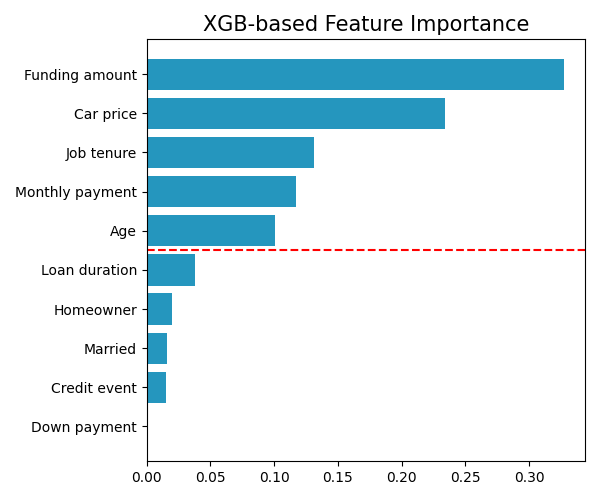

In [62]:
exp.feature_select(method="pfi", threshold=0.9, figsize=(6, 5))

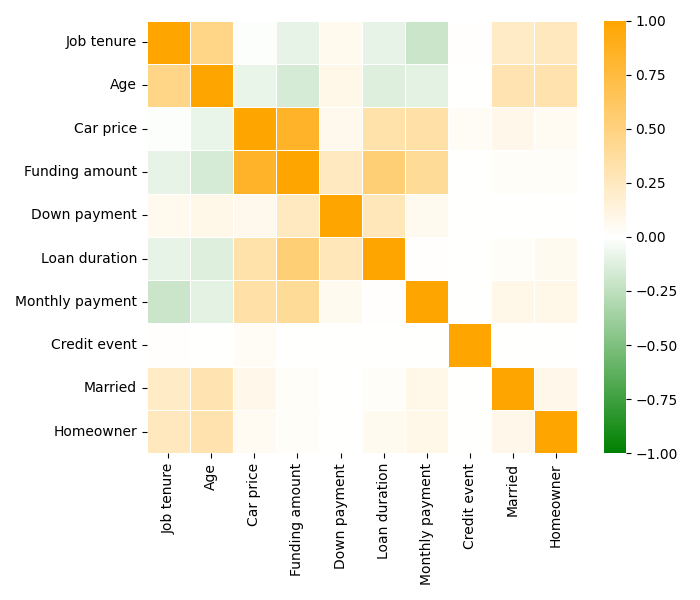

In [75]:
exp.eda(show='multivariate', multi_type='correlation_heatmap', figsize=(7, 6))

---

---

---

In [ ]:
import scipy

# **DEEP WHITE BOXES**

In [56]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from piml.models import ReluDNNClassifier
from sklearn.metrics import roc_auc_score


relu = make_imb_pipeline(ReluDNNClassifier(hidden_layer_sizes=(40, 40), l1_reg=0.0008,
                        batch_size=500, learning_rate=0.001))
relu.name = "ReluDNN"
evaluate_classifier(relu)

(0.553, 0.782)

In [53]:
from piml.models import XGB2Classifier


xgb =XGB2Classifier()

evaluate_classifier(xgb)

(0.565, 0.762)

In [54]:
from piml.models import GAMINetClassifier

gam = make_imb_pipeline(SMOTE(),GAMINetClassifier())

gam.name = "GAMINet + SMOTE"

evaluate_classifier(gam)

KeyboardInterrupt: 

In [77]:
## ReLU-DNN: ReLU Deep Neural Networks with L1-Regularization, e.g. L1_reg = 0.0008
from piml.models import ReluDNNClassifier

clf1 = ReluDNNClassifier(hidden_layer_sizes=(40, 40), l1_reg=0.0008,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf1, name='ReLU-DNN')

exp.model_diagnose(model="ReLU-DNN", show='accuracy_table')

'The model is already registered.'

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.8058,0.7412,0.1202,0.4446,0.1409
Test,0.8065,0.7575,0.1000,0.4282,0.1378
Gap,0.0007,0.0163,-0.0202,-0.0164,-0.0031


In [ ]:
## ReLU-DNN: ReLU Deep Neural Networks with L1-Regularization, e.g. L1_reg = 0.0008
from piml.models import ReluDNNClassifier

parameters = {
    "hidden_layer_sizes": [(40, 40), (50, 50), (60, 60)],
    "l1_reg": [0.0008, 0.001, 0.0012],
    "batch_size": [500, 1000, 2000],
    "learning_rate": [0.001, 0.01, 0.1]
}

result = exp.model_tune("ReLU-DNN", method="randomized", parameters=parameters, n_runs=100, metric="AUC", test_ratio=0.2)
params = result.get_params_ranks(rank=1)
exp.model_train(ReluDNNClassifier(**params), name="ReLU-DNN-FT")

exp.model_diagnose(model="ReLU-DNN-FT", show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.8090,0.7558,0.1634,0.4346,0.1388
Test,0.8065,0.7720,0.1111,0.4199,0.1340
Gap,-0.0025,0.0162,-0.0522,-0.0148,-0.0047


In [ ]:
from piml.models import GAMINetClassifier

gam = GAMINetClassifier()
exp.model_train(model=gam, name="GAMI-Net")

parameters = {
    "interact_num": [10, 20, 30],
    "loss_threshold": [0.01, 0.1, 0.2]
}

result = exp.model_tune("GAMI-Net", method="randomized", parameters=parameters, n_runs=100,
                        metric="AUC", test_ratio=0.2)
params = result.get_params_ranks(rank=1)
exp.model_train(GAMINetClassifier(**params), name="GAMI-Net")

exp.model_diagnose(model="GAMI-Net", show='accuracy_table')

'The model is already registered.'

'The model is already registered.'

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.8071,0.7576,0.1823,0.4334,0.1379
Test,0.8044,0.7632,0.1466,0.4242,0.1362
Gap,-0.0027,0.0056,-0.0357,-0.0092,-0.0017


In [78]:
from piml.models import XGB2Classifier
exp.model_train(model=XGB2Classifier(), name="XGB2")
exp.model_diagnose(model="XGB2", show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.8281,0.8127,0.3513,0.3944,0.1243
Test,0.8071,0.7723,0.2622,0.4208,0.1352
Gap,-0.0210,-0.0404,-0.0891,0.0264,0.0109


In [132]:
from piml.models import TreeClassifier
exp.model_train(model=TreeClassifier(), name="Tree")
exp.model_diagnose(model="Tree", show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.9517,0.7854,0.1037,0.1652,0.0422
Test,0.9505,0.6476,0.0882,0.3061,0.0478
Gap,-0.0012,-0.1379,-0.0155,0.1408,0.0056


# **BLACK BOXES**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
exp.model_train(model=clf, name='RandomForestClassifier')

parameters = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, 50],
    "min_samples_split": [2, 6,10],
    "min_samples_leaf": [1, 5]
}

result = exp.model_tune("RandomForestClassifier", method="randomized", parameters=parameters, n_runs=100,
                        metric="AUC", test_ratio=0.2)
params = result.get_params_ranks(rank=1)
exp.model_train(RandomForestClassifier(**params), name="RandomForestClassifier-FT")

exp.model_diagnose(model="RandomForestClassifier", show='accuracy_table')

'The model is already registered.'

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,1.0000,1.0000,1.0000,0.1136,0.0203
Test,0.8065,0.7280,0.2976,0.5356,0.1418
Gap,-0.1935,-0.2720,-0.7024,0.4219,0.1214


In [79]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
exp.model_train(model=xgb, name='XGBClassifier')
exp.model_diagnose(model="XGBClassifier", show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.9336,0.9846,0.8083,0.2043,0.0556
Test,0.7950,0.7347,0.3021,0.4709,0.1495
Gap,-0.1386,-0.2498,-0.5063,0.2666,0.0939


In [80]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
exp.model_train(model=mlp, name='MLPClassifier')
exp.model_diagnose(model="MLPClassifier", show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.8101,0.7603,0.2719,0.4315,0.1366
Test,0.8132,0.7667,0.2606,0.4211,0.1347
Gap,0.0030,0.0065,-0.0113,-0.0105,-0.0018


# **WHITE BOXES**

In [ ]:
from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear')
exp.model_train(model=lreg, name='LogisticRegression')
exp.model_diagnose(model="LogisticRegression", show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.8043,0.7413,0.1364,0.4451,0.1409
Test,0.8044,0.7569,0.1155,0.4290,0.1382
Gap,0.0002,0.0156,-0.0209,-0.0161,-0.0027


In [81]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
exp.model_train(model=knn, name='KNeighborsClassifier')
exp.model_diagnose(model="KNeighborsClassifier", show='accuracy_table')

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.8436,0.8678,0.5019,0.3234,0.1085
Test,0.7950,0.6648,0.3207,2.1174,0.1596
Gap,-0.0486,-0.2030,-0.1812,1.7940,0.0511


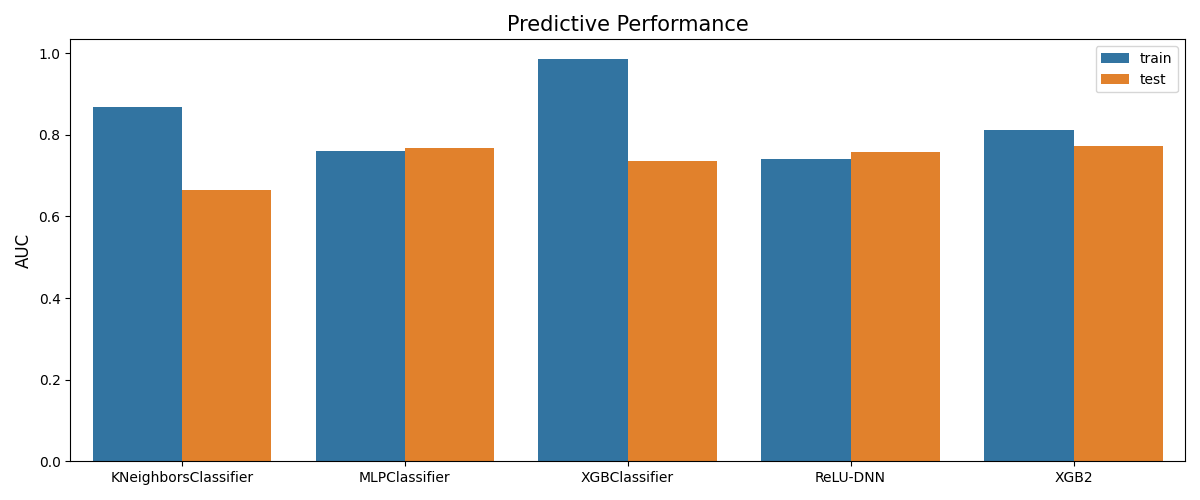

In [87]:
exp.model_compare(models=["KNeighborsClassifier","MLPClassifier", "XGBClassifier", "ReLU-DNN", "XGB2"], show="accuracy_plot", metric="AUC", figsize=(12, 5))

In [136]:
exp.model_interpret(model="XGB2", show="local_fi", sample_id=39, centered=False, original_scale=True, figsize=(6, 4))

'XGB2 is not registered yet.'

AttributeError: 'NoneType' object has no attribute 'estimator'

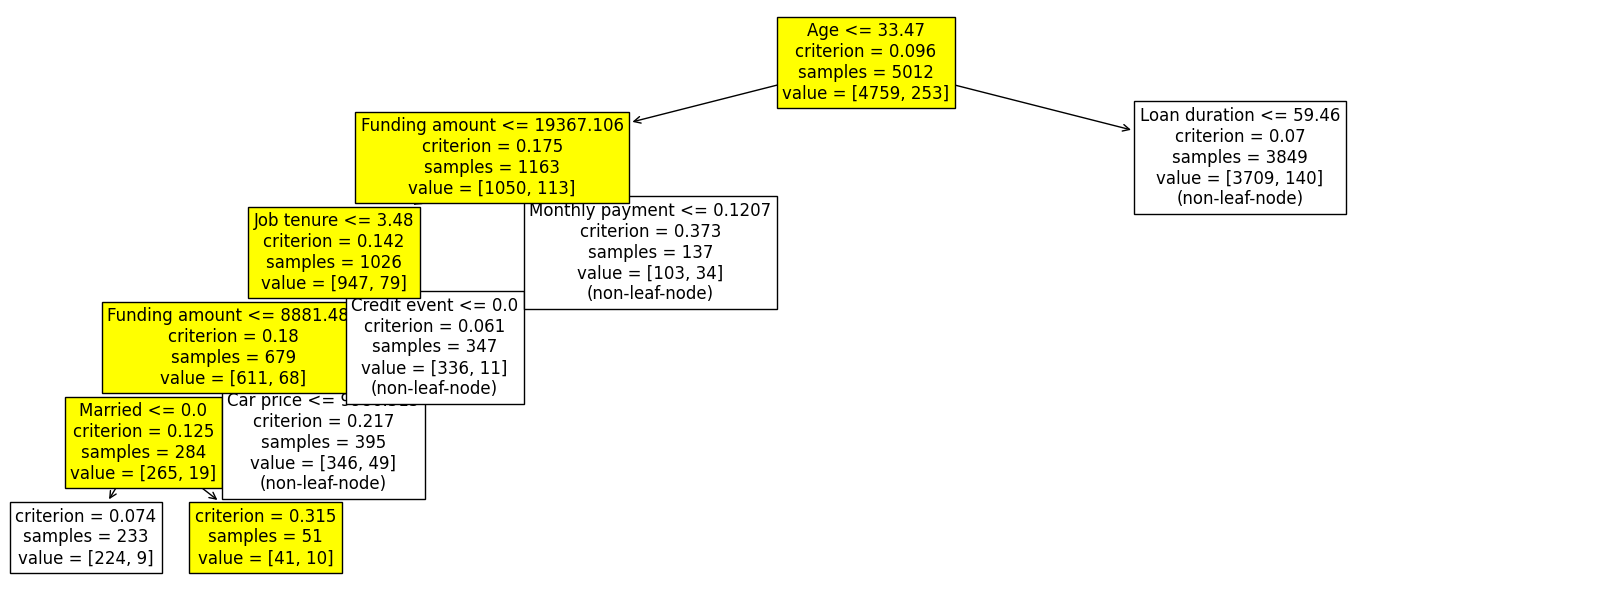

In [135]:
exp.model_interpret(model="Tree", show="tree_local", sample_id=36, original_scale=True, figsize=(16, 6))

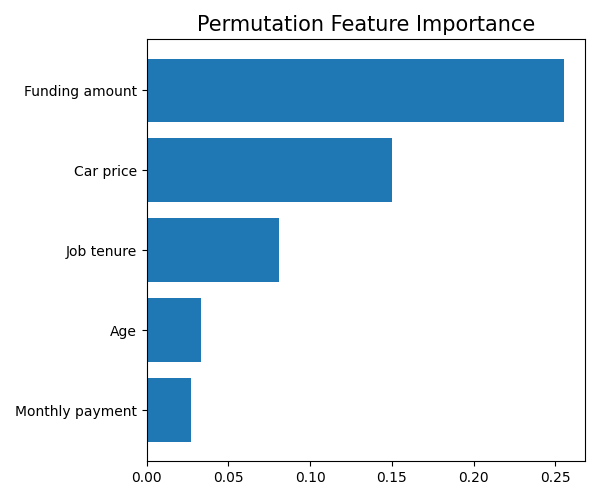

In [88]:
exp.model_explain(model='XGB2', show='pfi', sample_size=20, figsize=(6, 5))

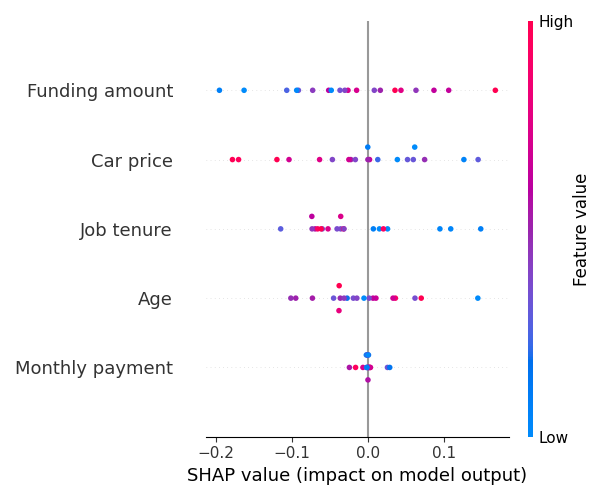

In [89]:
exp.model_explain(model='KNeighborsClassifier', show='shap_summary', sample_size=20, figsize=(6, 5))

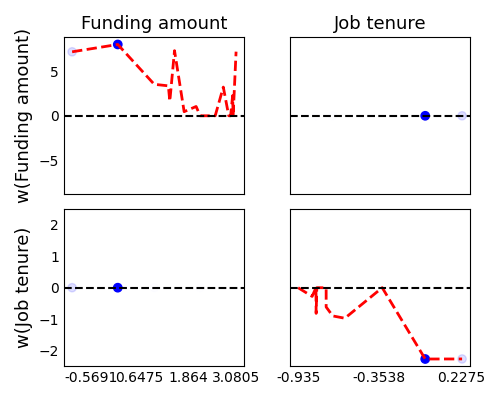

In [98]:
exp.model_interpret(model="ReLU-DNN", show="global_effect_plot", bi_features=["Funding amount", "Job tenure"],
                    original_scale=True, figsize=(5, 4))